# 1. Fundamentos de *Machine Learning*

En este notebook se revisarán los conceptos de:

1. Notación
2. Vecinos más próximos
3. Evaluación del modelo: entrenamiento y test
4. Selección del modelo: validación cruzada
5. Conceptos fundamentales de ML
  1. Compromiso sesgo-varianza
  2. Curvas de aprendizaje

Primero cargamos librerías y funciones necesarias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [2]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary(X,y,h,model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Zd = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y,ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1,2,1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    #plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 

# ejecute esta celda
def miRegresionLineal(x_i,y_i,x,y,degree):
    poly = PolynomialFeatures(degree)
    X_i  = poly.fit_transform(x_i.reshape(-1, 1))
    X_test = poly.fit_transform(x.reshape(-1, 1))
    lr     = LinearRegression().fit(X_i,y_i)
    
    y_hat = lr.predict(X_i)
    fw = lr.predict(X_test)
    
    error_train = np.mean(np.power(y_i-y_hat,2)) 
    error_test  = np.mean(np.power(y-fw,2)) 
    
   # print(lr.coef_)
    
    return fw, error_test, error_train

# 1. Notación

Echa un vistazo a los [datasets](http://scikit-learn.org/stable/datasets/index.html) de sklearn.

In [4]:
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

len(np.unique(y))

214

<div class = "alert alert-success">
EJERCICIO: Sobre el conjunto de datos anterior, indique si se trata de un problema de clasificación o de regresión, y calcule los siguientes valores:
</div>

* $N$: número de muestras
* $d$: dimensionalidad del espacio de entrada
* $\mathbf{x}^{(10)}$: muestra $i=10$
* $\mathbf{x}_1$: característica/variable/*feature* $1$ 


# 2. Vecinos más próximos

En este notebook vamos a trabajar con el algoritmo de KNN en distintos problemas de **clasificación**.

## 2.1. Medida de las prestaciones de un clasificador

Por clasificador entendemos un algoritmo que, a partir de un conjunto de muestras/observaciones de entrenamiento, es capaz de identificar que identifica a qué clase (categoría) pertenece una nueva observación.

Una métrica de calidad que podemos usar para medir las prestaciones de un clasificador es el **error de clasificación**

$$\textrm{Error} = \frac{\textrm{# muestras mal clasificadas}}{\textrm{# de muestras total del problema}}$$

* Ejemplo: problema de clasificación con dos clases $y\in{0,1}$
    * Etiquetas reales (*y_true*) = $[1,0,0,1,0]$
    * Etiquetas predichas (*y_pred*) = $[0,0,1,1,0]$
    
    * En este caso: $$\textrm{Error} = \frac{\textrm{# muestras mal clasificadas} = 2}{\textrm{# de muestras total del problema} = 5} = \frac{2}{5} = 0.4$$

Así, el error de clasificación será un número entre 0 y 1, tal que:

* $\textrm{Error} = 0$ es el mejor valor posible (no me equivoco nada)
* $\textrm{Error} = 1$ es el peor valor posible (me equivoco en todas las muestras). Nota: si me equivoco en la clasificación de todas las muestras, entonces puedo interpretar que el clasificador es bueno, pero que tengo que hacer justo lo contrario de lo que me dice. El peor valor de error sería por tanto $0.5$, en el que la incertidumbre es mayor. 

Normalmente no se utiliza el error, sino su complementario, la exactitud o [**accuracy**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (Acc):

$$\textrm{Acc} = 1 - \textrm{Error}$$

y entonces:

* $\textrm{Acc} = 1$ es el mejor valor posible (no me equivoco nada)
* $\textrm{Acc} = 0$ es el peor valor posible (me equivoco en todas las muestras)

## 2.2 Ejemplos

Para analizar el comportamiento del algoritmo de K-NN, utilizaremos tres ejemplos sencillos, como mostraremos a continuación

In [5]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])
ejemplo1.head()

,x1,x2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


<div class = "alert alert-success">
EJERCICIO: ¿Habéis trabajado con pandas anteriormente?
</div>

In [6]:
ejemplo1.describe()

,x1,x2,label
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


Representemos

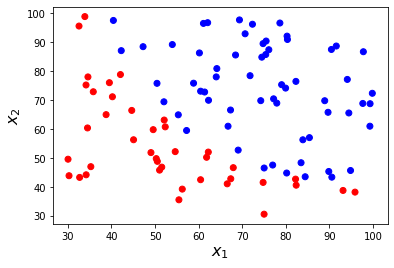

In [7]:
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Se dice que este problema es **linealmente separable**, porque podemos trazar una recta para separar (no de forma perfecta) las dos clases (representadas en distintos colores, rojo y azul).
* En el plano bidimensional: recta
* En un espacio d-dimensional: hiperplano

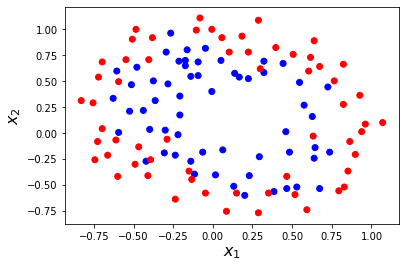

In [8]:
# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Se dice que este problema es **no linealmente separable**, porque no podemos trazar una recta para separar las dos clase (representadas en distintos colores, rojo y azul).

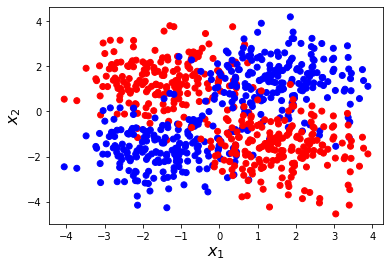

In [9]:
# ejemplo 3: Problema XOR 
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1,X2))

plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Al igual que en el caso anterior, este ejemplo tampoco es linealmente separable, y se conoce como problema XOR. La ventaja del problema XOR es que conocemos cuál es la frontera de separación óptima a priori:

- Clase 1, color azul: $x_1,x_2 > 0$, y $ x_1,x_2 < 0$ (cuadrantes 1 y 3)
- Clase 2, color rojo: $x_1 < 0,  x_2 > 0$, y $x_1 > 0,  x_2 < 0$ (cuadrantes 2 y 4)

## 2.3 Entrenar el modelo 

Vamos a entrenar un modelo K-NN para los distintos ejemplos:

<div class = "alert alert-success">
EJERCICIO: Echa un vistazo a la [documentación](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) del modelo K-NN en sklearn
</div>

C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


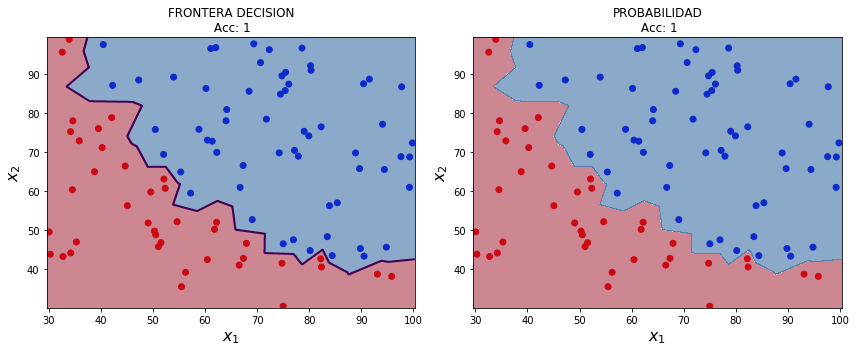

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Ejemplo 1
# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo y ajustamos
knnModel = KNeighborsClassifier(n_neighbors=1)
knnModel.fit(X1,y1)

plot_decision_boundary(X1,y1,0.05,knnModel)

**Número de vecinos**

Podemos modificar el número de vecinos $k$ del algoritmo k-nn implementado en scikit-learn mediante el parámetro *n_neighbors*. Por defecto, [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) toma *n_neighbors* $=5$

<div class = "alert alert-success">
EJERCICIO: Varía el valor de *n_neighbors*, ¿qué sucede ahora?
</div>

<div class = "alert alert-success">
EJERCICIO: Aplica el algoritmo K-NN sobre los ejemplos 2 y 3. ¿Qué sucedería si aplicamos sobre estos ejemplos un algoritmo de [regresión logística](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)? ¿Qué pasa si variamos el número de vecinos?
</div>

In [11]:
# Ejemplo 2


In [12]:
# Ejemplo 3:


Podemos comprobar que las mejores prestaciones se obtienen cuando *n_neighbors=1*, ¿tiene sentido? ¿Estamos midiendo correctamente las prestaciones de este clasificador?

# 3. Evaluación del modelo: entrenamiento y test

La respuesta es claramente no. Para poder saber cómo de bien se comporta un algoritmo de machine learning, hemos de medir su capacidad de [generalización](https://en.wikipedia.org/wiki/Generalization_error), esto es, las prestaciones en muestras no vistas previamente por el clasificador. Para ello, dividimos el conjunto de entrenamiento en dos partes, entrenamiento y test, teniendo en cuenta que:

![](./figuras/train_test_set_2d_classification.png)

* Utilizamos aproximadamente un 70-75% de las muestras para entrenamiento y un 30-25% para el test.
* Ambos conjuntos han de representar la población con la misma estadística: 
    * Randomizar, esto es, reordenar para evitar orden en las muestras. (cuidado series temporales)
    * Estratificar con respecto a una variable (normalmente la variable target), para mantener la proporción de la varible target en los conjuntos train/test.

sklern nos proporciona una [función](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para dividir nuestros datos. 

<div class = "alert alert-success">
EJERCICIO: Echa un vistazo a la documentación de la función.
</div>

Vamos a probar con el primer ejemplo:

C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


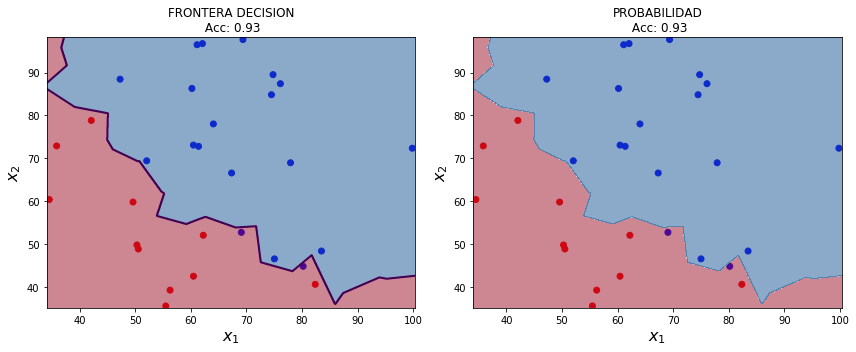

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, shuffle = True, random_state = 0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

plot_decision_boundary(X_test,y_test,0.05,knn)

<div class = "alert alert-success">
EJERCICIO: Sobre la celda anterior, varía el valor de *n_neighbors*. ¿Para qué valor se obtienen ahora las mejores prestaciones? ¿Qué sucede si eliminamos *random_state = 0* y ejecutamos varias veces la misma celda para un valor de *n_neighbors* fijo? ¿Obtenemos las mismas prestaciones? ¿Y si estratificamos?
</div>

<div class = "alert alert-success">
EJERCICIO: Calcula las prestaciones del algoritmo K-NN para los ejemplos 2 y 3. 
</div>

In [14]:
# Ejemplo 2

In [15]:
# Ejemplo 3

<div class = "alert alert-success">
EJERCICIO (AVANZADO): Representa las prestaciones del algoritmo K-NN en entrenamiento y test para distintos valores de *n_neighbors* (entre 1 y 15), utilizando el ejemplo 3. 
</div>

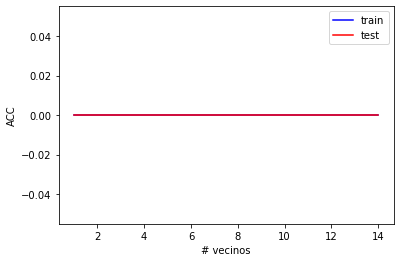

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0)

# inicializamos
neighbors = range(1,15)
acc_train = []
acc_test  = []

for n in neighbors:
    
    ################## tu código aquí
    
    
    #################
    
    acc_train.append(knn.score(X_train, y_train))
    acc_test.append(knn.score(X_test, y_test))
    

plt.plot(neighbors,acc_train,'b',label='train')
plt.plot(neighbors,acc_test,'r',label='test')
plt.legend()
plt.xlabel('# vecinos')
plt.ylabel('ACC')
plt.show()


El número de vecinos que escojamos afecta significativamente a las prestaciones del algoritmo. Este parámetro es un compromiso entre los errores que cometemos (*accuracy*) y la complejidad del modelo (frontera de separación). 

- Cuanto menor es el número de vecinos, **más compleja** es la frontera de separación, y por tanto mayor será el sobreajuste. Potencialmente empeorará la *accuracy*.
- Cuanto mayor es el número de vecinos, **menos compleja** es la frontera de separación y por tanto menor será el sobreajuste. Potencialmente mejorará *accuracy*.

## 3.1 Conclusiones

1. Si las muestras de entrenamiento son escasas (ejemplo 1), el error en test puede ser muy variable , dependiendo de las muestras incluidas en el conjunto de entrenamiento y el conjunto de test.

2. Las prestaciones (en test), dependen del número de vecinos que determinan la complejidad de la frontera de separación.

Teniendo en cuenta 1 y 2, ¿cómo puedo escoger el valor óptimo de *n_neighbors*?


# 4. Selección del modelo: validación cruzada

La validación cruzada (o cross-validation) consiste en subdivir el conjunto de entrenamiento en $K$ partes iguales, de tal forma que se utilizan $K-1$ para entrenar (ajustar el modelo) y el bloque $k$ restante para evaluar las prestaciones en función de los parámetros libres. Este proceso se repite $K$ veces (hasta que se barren todos los bloques) y los resultados se promedian.

Por suerte, no es necesario programar estas subdivisiones, porque scikit-learn tiene un clase que realiza este trabajo por nosotros. Puedes consultarlo [aquí](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

Vamos a buscar el valor óptimo del número de vecinos utilizando una estrategia 5-fold CV.

In [17]:
from sklearn.model_selection import StratifiedKFold

# recordemos que este es nuestro conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0)

nFolds = 5 #scikit-learn los llama splits
kf  = StratifiedKFold(n_splits = nFolds, shuffle = True, random_state=0)

nVecinos = range(1,16) # [1-15]

# inicializamos una matriz de errores, para cada valor de n_neighbors y cada iteración del algoritmo de cross-validation
# - tantas filas como número de folds
# - tantas columnas como valores de alphaVector
accMatriz = np.zeros((nFolds,len(nVecinos))) 

j = 0 # inicializamos contador de columnas
for n in nVecinos:
       
    knn = KNeighborsClassifier(n_neighbors = n)
    
    i = 0 # inicializamos contador de filas
    for idxTrain, idxVal in kf.split(X_train,y_train):
      
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        knn.fit(Xt,yt)
        accMatriz[i,j] = knn.score(Xv, yv) 
        
        i+=1
    j+=1

accVector = np.mean(accMatriz,axis=0)
accStd = np.std(accMatriz,axis=0)

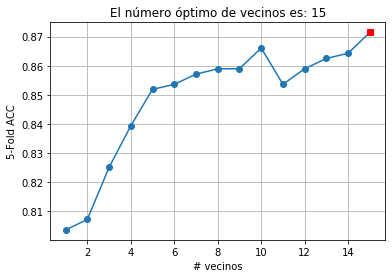

In [18]:
# Calculamos el valor óptimo
idx = np.argmax(accVector)
nOpt = nVecinos[idx]

plt.plot(nVecinos,accVector,'-o')
plt.plot(nVecinos[idx],accVector[idx],'rs')
plt.title('El número óptimo de vecinos es: %d' % nOpt)
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

Representemos ahora la gráfica anterior con la variación (desviación estándar) de la *accuracy* en cada *fold*. 

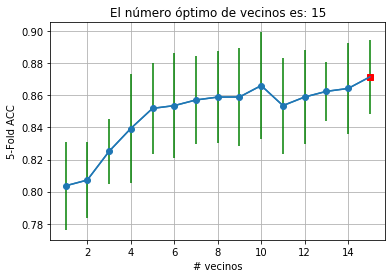

In [19]:
plt.plot(nVecinos,accVector,'-o')
plt.plot(nVecinos[idx],accVector[idx],'rs')
plt.errorbar(nVecinos, accVector, yerr=accStd, ecolor='g')
plt.title('El número óptimo de vecinos es: %d' % nOpt)
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

In [20]:
# Damos las prestaciones reales del modelo (en test)
knn = KNeighborsClassifier(n_neighbors = nOpt)
knn.fit(X_train,y_train)

print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))

accuracy: 0.83


El código anterior se puede reducir drásticamente si utilizamos [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

best mean cross-validation score: 0.863
best parameters: {'n_neighbors': 9}


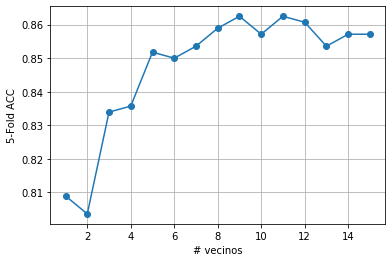

acc (test): 0.85


In [21]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0)

param_grid = {'n_neighbors':  np.arange(1, 16, 1)}
grid = GridSearchCV(KNeighborsClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos,scores,'-o')
#plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

# 5. ¿Cómo elegimos el algoritmo adecuado?

No hay *free lunch*, ningún método/algoritmo es mejor que otro para todos los problemas (conjuntos de datos). Para entender si el algoritmo adecuado se comporta adecuadamente, hay que tener en cuenta:

- Ruido en los datos (error irreducible)
- Número de ejemplos disponibles
- Número de características (dimensionalidad del problema)

## 5.1 Compromiso sesgo-varianza

Este principio permite analizar el alcance de las prestaciones (error de generalización) en tareas de aprendizaje supervisado. 

Supongamos que tenemos un proceso $y = g(x) + \epsilon$, donde $\epsilon$ representa una fuente de error irreducible (ruido en los datos). Del proceso $y$, tenemos información de un conjunto de muestras  $D = \{x^{(i)},y^{(i)}\}$, con $i=1,\ldots,N$. 

A partir de estos datos $D$, buscamos encontrar la función $f_{\omega}(x)$ que *mejor se ajuste* a la verdadera función $g(x)$, utilizando un algoritmo de *machine learning*. Por mejor ajuste se entiende que se quiere medir el error cuadrático medio $\left(y - f_{\omega}(x)\right)^2$, tanto para el conjunto $D$, como para cualquier muestra no contenida en $D$ (capacidad de generalización). 

Dado que $y$ es un proceso que contiene ruido, es difícil que podamos ajustar $f_{\omega}(x)$ a $g(x)$ de forma perfecta. Se puede demostrar que, en promedio, el error que se comete para cualquier valor de $x\notin D$ (error de generalización), se descompone en:

$$ \textrm{error}(x) = E\Big[\big(y - f_{\omega}(x)\big)^2\Big] = \textrm{Bias}\big[f_{\omega}(x)\big]^2 + \textrm{Var}\big[f_{\omega}(x)\big] + \sigma^2 $$

Donde:

* $\textrm{Bias}\big[f_{\omega}(x)\big]^2 = E\Big[f_{\omega}(x)\Big]^2 - g(x)$ representa el error asociado a la simplicidad del modelo.
* $\textrm{Var}\big[f_{\omega}(x)\big]$ representa la variabilidad del modelo frente a distintos conjuntos de entrenamiento. Pequeños cambios en el conjunto de entrenamiento pueden producir grandes errores.
* $\sigma^2$ es una cota al error mínimo que puedo alcanzar. 

Por tanto, el objetivo es buscar un algoritmo que proporcione mínimo sesgo y mínima varianza.

### 5.1.1 Ejemplo

Veamos con un ejemplo. Supongamos que $y = g(x) + \epsilon$, donde:

* $g(x) = \cos{(1.5\pi x})$, $x \in [0,1]$
* $\epsilon \sim N(0,\sigma^2)$, $\sigma = 0.2$
* Disponemos del conjunto de datos $D = \{x^{(i)},y^{(i)}\}$, con $i=1,\ldots,N$. 

Queremos estimar $g(x)$ a partir del conjunto de datos $D$ disponible. Para ello, vamos a utilizar tres funciones:

* Regresión lineal orden 1: modelo **sencillo** $$f^1_{\omega}(x) = \omega_0 + \omega_1 x$$ 
* Regresión lineal orden 4: modelo **intermedio** $$f^4_{\omega}(x) = \omega_0 + \omega_1 x + \omega_2 x^2 + \omega_3 x^3 + \omega_4 x^4$$ 
* regresión lineal orden 7: modelo **flexible** (complejo) $$f^{7}_{\omega}(x) = \omega_0 + \sum_{j=1}^{7}\omega_j x^j$$ 

<div class = "alert alert-success">
EJERCICIO: dibuje la función $g(x)$, y el conjunto de datos $D = \{x^{(i)},y^{(i)}\}$
</div>

In [22]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# YOUR CODE HERE: dibuje la función g(x), y el conjunto de datos x_i,y_i
########



########

A continuación representamos la salida obtenida y el error cometido para las tres funciones definidas.

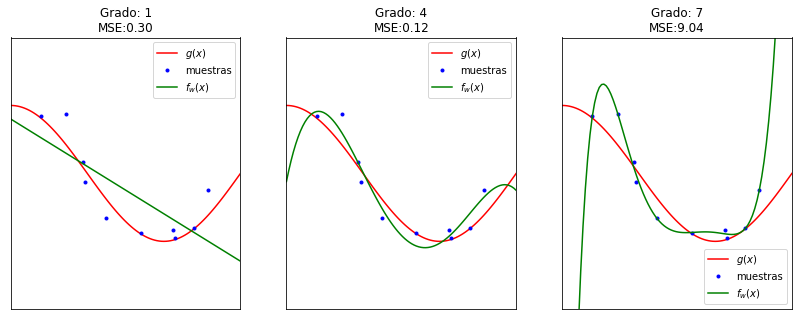

In [23]:
# Ejecute esta celda
grado_polinomio = [1,4,7]

#idx = np.random.randint(0,N_test,N_train)
#x_i = x[idx]
#y_i = y[idx]

plt.figure(figsize=(14, 5))
for j,d in enumerate(grado_polinomio):
    
    f_k, mse, _ = miRegresionLineal(x_i,y_i,x,y,d)
    
    ax = plt.subplot(1, 3, j+1)
    plt.setp(ax, xticks=(), yticks=())
    plt.plot(x,g_x,'r',label='$g(x)$')
    plt.plot(x_i,y_i,'b.',label='muestras')
    plt.plot(x,f_k,'g',label='$f_w(x)$')
    plt.title('Grado: %i\nMSE:%.2f'%(d,mse))
    plt.legend()
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    
plt.show()

Se puede comprobar que el modelo de orden 7 se **sobreajusta** a las muestras de entrenamiento (la función pasa por los puntos de entrenamiento), y por tanto su capacidad de generalización es muy limitada.

<div class = "alert alert-success">
EJERCICIO: Descomente las líneas de código y vuelva a ejecutar la celda, ¿qué resultado obtiene ahora?
</div>

Por tanto, para analizar el sesgo y la varianza de los modelos anteriores, tenemos que calcular sus prestaciones para distintos conjuntos de entrenamiento, y posteriormente calcular su media y su varianza.

<div class = "alert alert-success">
EJERCICIO: En la siguiente celda, escribe el código obtener una nuevo conjunto de datos $D = \{x^{(i)},y^{(i)}\}$ para cada repetición del experimento.
</div>

C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

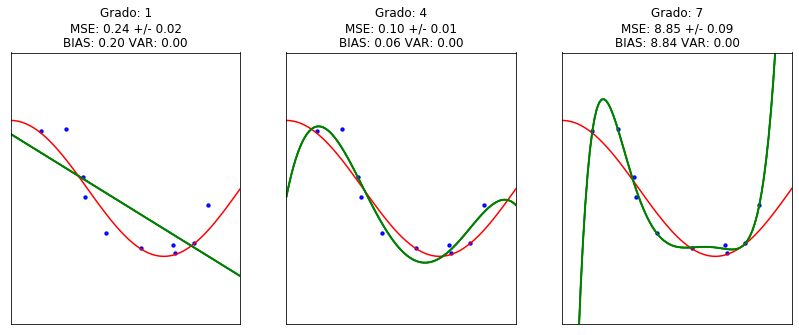

In [24]:
N = 10
grado_polinomio = [1,4,7]
Nrepeticiones = 20

# inicializamos
mse  = np.zeros((len(grado_polinomio),Nrepeticiones))
f_w  = np.zeros((Nrepeticiones,N_test,len(grado_polinomio)))
np.random.seed(0)

plt.figure(figsize=(14, 5))
for k in range(Nrepeticiones):
    
    y = g_x + np.random.randn(N_test) * 0.2
    
    #### YOUR CODE HERE: (~3 lines). Obten las muestras de un nuevo conjunto de entrenamiento
    
    
    
    #####
    
    for j,d in enumerate(grado_polinomio):

        f_k, mse[j,k], _ = miRegresionLineal(x_i,y_i,x,y,d)
        f_w[k,:,j] = f_k

        ax = plt.subplot(1, 3, j+1)
        plt.plot(x_i,y_i,'b.',alpha=0.1)
        plt.plot(x,f_k,'g',alpha=0.1)
        

for j,d in enumerate(grado_polinomio):
    ax = plt.subplot(1, 3, j+1)
    f_k = np.mean(f_w[:,:,j],axis=0)
    
    bias = g_x - f_k
    var = np.var(f_w[:,:,j],axis=0)
        
    plt.setp(ax, xticks=(), yticks=())
    plt.plot(x,g_x,'r')
    plt.plot(x,f_k,'g',linewidth=2)
    plt.title('Grado: %i\nMSE: %.2f +/- %.2f\nBIAS: %.2f VAR: %.2f'%(d,
                                                                     np.mean(mse[j,:]),
                                                                     np.std(mse[j,:]),
                                                                     np.mean(bias**2),
                                                                     np.mean(var)))
    plt.ylim((-2, 2))
    plt.xlim((0, 1))
    
plt.show()



El resultado anterior nos indica que modelos muy complejos tienden a sobreajustarse a los datos (alta varianza), mientras que modelos muy sencillos (alto sesgo), no consiguen aproximarse adecuadamente. Así, el compromiso buscar un algoritmo que tenga mínimo sesgo y mínima varianza.

Así: 

* Para reducir el sesgo, se necesitan modelos más complejos
* Para reducir la varianza, se necesita reducir la complejidad. Una opción es aumentar el número de muestras de entrenamiento. 


<div class = "alert alert-success">
EJERCICIO (Avanzado): Represente el error cuadrático medio (entrenamiento y test) para distintos niveles de complejidad del algoritmo de regresión lineal (distintos grados del polinomio)
</div>

In [25]:
N = 50
grado_polinomio = [1,2,3,4,5,6,7,8,9,10,11,12]
Nrepeticiones = 100

# inicializamos
mse_test  = np.zeros((len(grado_polinomio),Nrepeticiones))
mse_train  = np.zeros((len(grado_polinomio),Nrepeticiones))
np.random.seed(0)

for k in range(Nrepeticiones):
    
    y = g_x + np.random.randn(N_test) * 1
    
    idx = np.random.randint(0,N_test,N)
    x_i = x[idx]
    y_i = y[idx]
    
    for j,d in enumerate(grado_polinomio):

        _, mse_test[j,k], mse_train[j,k] = miRegresionLineal(x_i,y_i,x,y,d)

# YOUR CODE HERE



Deberías obtener algo como:

![](figuras/entrenamiento_test_complejidad.png)

Fuente: *The Elements of Statistical Learning*

Por tanto, examinando la diferencia en las prestaciones entre el conjunto de entrenamiento/validación y test, puedes saber si estás en alguna de las siguientes situaciones:

* **Alto sesgo**: error de entrenamiento/validación y error en test similar, pero muy alto. Cuando esto sucede podemos
    * Aumentar el número de variables / características
    * Aumentar el grado del polinomio (mayor complejidad)
* **Alta varianza**: gran diferencia entre error de entrenamiento/validación y test con un error de entrenamiento pequeño
    * Aumentar el número de muestras de entrenamiento
    * Reducir el número de variables / características


## 5.2 Número de ejemplos disponibles

De la discusión anterior podemos pensar que cuando tratamos con un problema muy complejo, utilizar más muestras de entrenamiento siempre nos va a ayudar, así que deberíamos dedicar muchos esfuerzo en conseguir muchos ejemplos. Pues bien, esto no es del todo cierto, y para ello podemos representar las curvas de aprendizaje o *learning curves*, las cuales representan la evolución de las prestaciones de un algoritmo supervisado (entrenamiento/validación y test) frente al número de muestras utilizadas. 

Estas curvas tienen un aspecto como

![](figuras/learning_curves.png)





<div class = "alert alert-success">
EJERCICIO: ¿Podrías decir cuál de las curvas anteriores se corresponde con un problema de alto sesgo/varianza?
</div>

## 5.3 Dimensionalidad

Hace referencia al número de características que podemos utilizar en un problema de aprendizaje automático. Hay que tener en cuenta el principio de la [Maldición de la dimensionalidad](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Este principio indica que a medida que el número de variables o características aumenta, el número de muestras de entrenamiento que necesitamos para generalizar correctamente aumenta exponencialmente.

Así, también se puede controlar la complejidad (varianza), modificando el número de características. Técnicas como selección de características, resultan pues de utilidad.

# Referencias

1. Capítulo 2. An Introduction to Statistical Learning. 
2. https://en.wikipedia.org/wiki/Bias–variance_tradeoff
3. http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html